In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [14]:
# Load cleaned business analytics dataset
df = pd.read_csv("hotel_booking_business_analytics.csv")

# Ensure the date column is in datetime format
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Aggregate ADR & total revenue per month
df['year_month'] = df['reservation_status_date'].dt.to_period('M')
monthly_revenue = df.groupby('year_month').agg({'adr': 'mean', 'total_revenue': 'sum'}).reset_index()

# Convert year_month to datetime for Prophet
monthly_revenue['year_month'] = monthly_revenue['year_month'].astype(str)
monthly_revenue['year_month'] = pd.to_datetime(monthly_revenue['year_month'])

# Verify the dataset
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_nights,is_family,total_revenue,year_month
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,0,False,0.0,2015-07
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,0,False,0.0,2015-07
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,1,False,75.0,2015-07
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,1,False,75.0,2015-07
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,2,False,196.0,2015-07


03:34:27 - cmdstanpy - INFO - Chain [1] start processing
03:34:27 - cmdstanpy - INFO - Chain [1] done processing


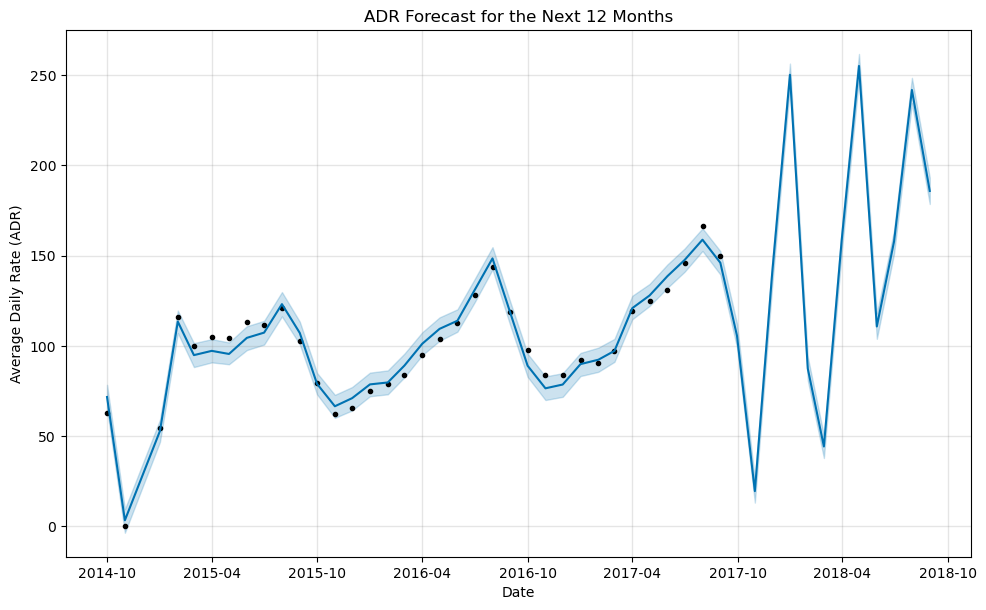

In [13]:
#Prophet Forecasting for ADR
#Why?
#Prepares data for Prophet (ds = date, y = ADR).
#Trains the model to predict ADR for the next 12 months.
#Plots the ADR forecast trend for better business insights.

# Prepare Prophet data for ADR forecasting
adr_data = monthly_revenue[['year_month', 'adr']]
adr_data.columns = ['ds', 'y']  # Rename columns for Prophet

# Initialize Prophet model with explicit seasonality settings
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Fit Prophet model
prophet_model.fit(adr_data)

# Create future dataframe (12 months ahead)
future = prophet_model.make_future_dataframe(periods=12, freq='M')

# Predict future ADR
forecast = prophet_model.predict(future)

# Plot ADR Forecast
fig = prophet_model.plot(forecast)
plt.title("ADR Forecast for the Next 12 Months")
plt.xlabel("Date")
plt.ylabel("Average Daily Rate (ADR)")
plt.show()

03:32:19 - cmdstanpy - INFO - Chain [1] start processing
03:32:19 - cmdstanpy - INFO - Chain [1] done processing


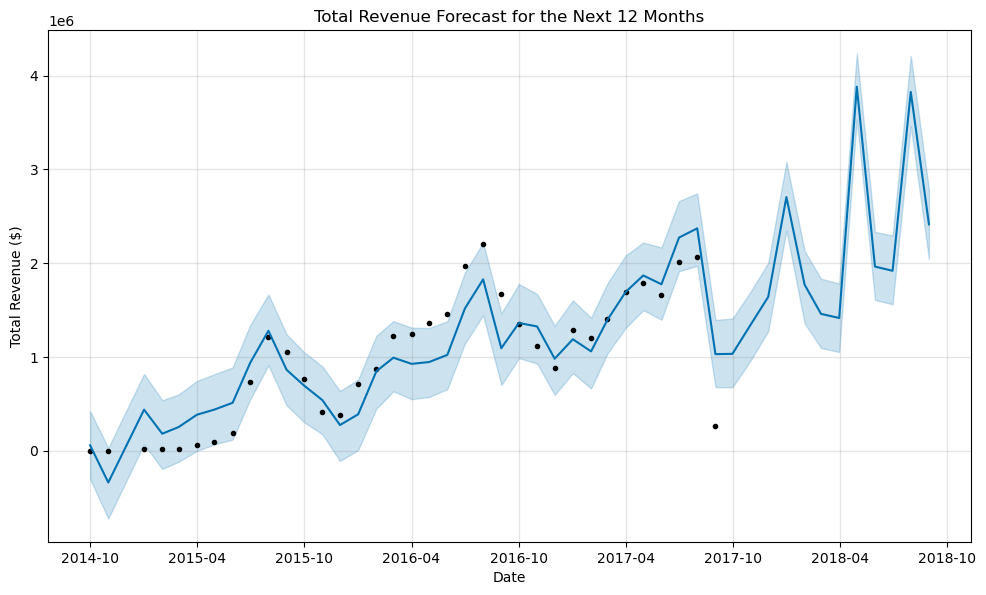

In [9]:
#Prophet Forecasting for Total Revenue trends
#Why?
#Forecasts revenue 12 months into the future.
#Plots revenue trends to assist financial planning.

# Prepare data for total revenue forecasting
revenue_data = monthly_revenue[['year_month', 'total_revenue']]
revenue_data.columns = ['ds', 'y']  # Rename columns for Prophet

# Initialize Prophet model with explicit seasonality settings
prophet_revenue_model = Prophet(yearly_seasonality=True)
prophet_revenue_model.add_seasonality(name='weekly', period=7, fourier_order=15)  # Add weekly seasonality

# Fit Prophet model
prophet_revenue_model.fit(revenue_data)

# Create future dataframe (12 months ahead)
future_revenue = prophet_revenue_model.make_future_dataframe(periods=12, freq='M')

# Predict future revenue
forecast_revenue = prophet_revenue_model.predict(future_revenue)

# Plot Total Revenue Forecast
fig = prophet_revenue_model.plot(forecast_revenue)
plt.title("Total Revenue Forecast for the Next 12 Months")
plt.xlabel("Date")
plt.ylabel("Total Revenue ($)")
plt.show()

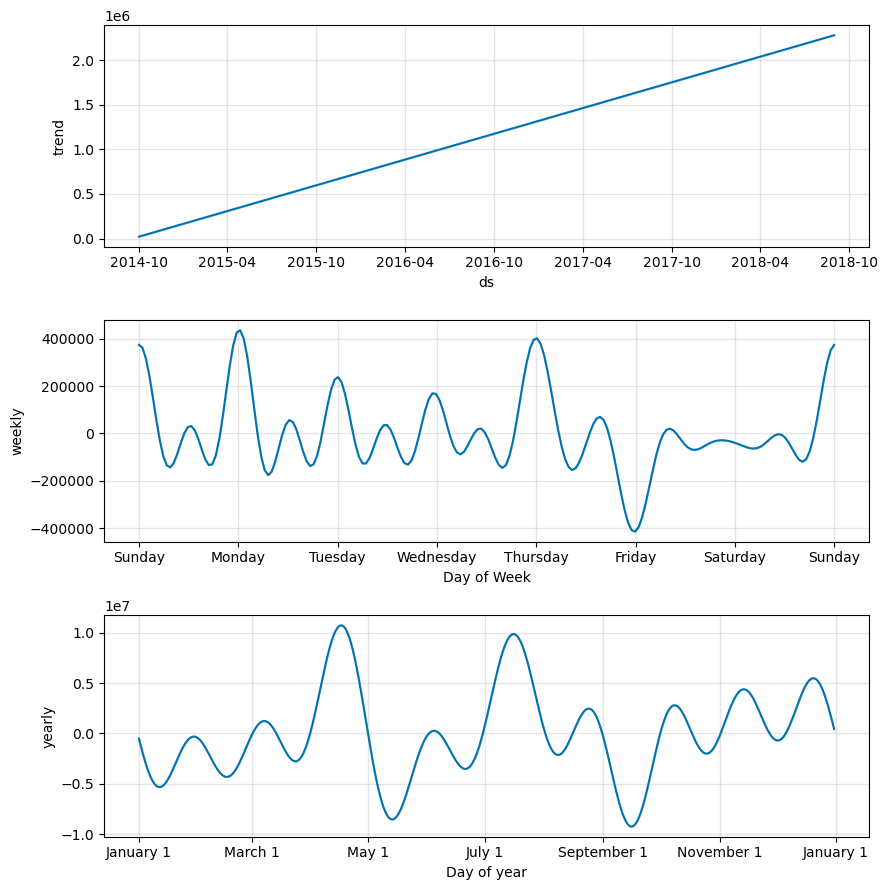

In [10]:
#Analyzing Weekly Seasonality in Revenue
#Why?
#Shows how revenue changes over time (yearly & weekly seasonality).
#Identifies high-revenue months & days to optimize pricing.

# Plot Prophet's seasonality components
fig = prophet_revenue_model.plot_components(forecast_revenue)
plt.show()

In [11]:
# XGBoost Regression for Revenue Prediction
#Why?
#Trains XGBoost regression model to predict total revenue.
#Uses ADR, lead time, total nights, and cancellations as predictors.
#Evaluates model performance using R², RMSE, MSE, and MAE.

# Feature Engineering - Creating total_nights column
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

# Selecting features and target variable (total revenue)
features = ['lead_time', 'adr', 'total_nights', 'is_canceled']
target = 'total_revenue'

# Splitting data into train and test sets
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Model Performance:
Mean Absolute Error (MAE): 3.17
Mean Squared Error (MSE): 125.44
Root Mean Squared Error (RMSE): 11.20
R² Score: 0.9991


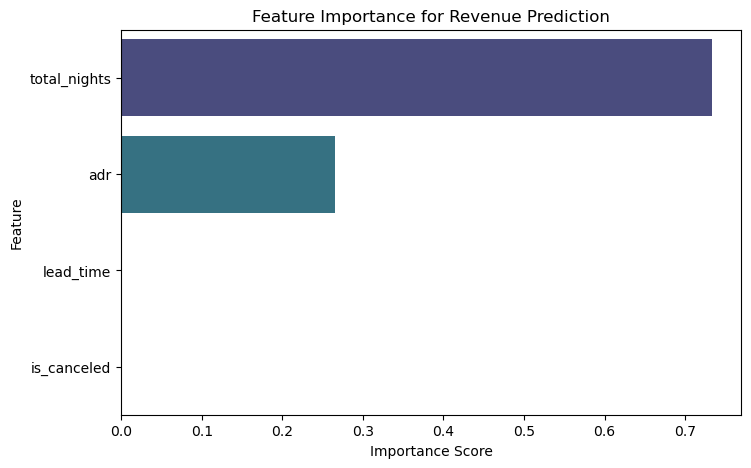

In [12]:
#Feature Importance Analysis
#Visualizes which features have the biggest impact on revenue.
#Helps identify key revenue drivers for better business decisions.

# Get feature importance from the trained XGBoost model
feature_importance = xgb_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title("Feature Importance for Revenue Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()